### Time Delay of Arrival using Publicly Available Data

The goal of this notebook is to demonstrate implementation of the Time delay of arrival (TDOA) method of triangulating the position of radio transients using public data only. 

This has recently been made much more tractable by the efforts of Dr. Vratislav Krupar (GSFC) in archiving the STEREO native cadence radio spectrograms as CDF files at ([STEREO A](https://cdaweb.gsfc.nasa.gov/pub/data/stereo/ahead/l3/waves/) [STEREO B](https://cdaweb.gsfc.nasa.gov/pub/data/stereo/behind/l3/waves/) ).

The methodology is described in Badman+[2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...938...95B/abstract). At its core, the procedure is quite simple. Assuming we have three spacecraft (e.g. A, B and C) located approximately co-planar (e.g. in the ecliptic plane) at 2D positions $(x,y)_{i={A,B,C}}$ which all receive the same radio signal at a given frequency $f$ at respective times $t_{i={A,B,C}}$, we can map these positions (assuming the radio source also is approximately co-planar) to a source origin position $(x_s(f),y_s(f))$ via an analytic construction. This construction essentially corresponds to intersecting two hyperbolae where the locations of the geometric foci are set by the positions of pairs of the spacecraft, and the hyperbola curvature are set by the relative time __delay__ of the measurement between those same two spacecraft  (see figure 11 in Badman+[2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...938...95B/abstract) ).

To go from a real set of radio observations to a radio burst trajectory, there are four steps :

* Download radio spectrogram data and slice to isolate the feature of interest in all spacecraft
* Produce the position vectors of the individual spacecraft at the time of interest.
* Process the spectrograms to perform feature extraction of the feature of interest, resulting in a 1d curve f=f(t).
* Use the extracted feature from all three spacecraft and iterate the analytical procedure as function fo frequency to derive the source position as a function of frequency.

#### Step 0 : Imports
Note the `sys.path.insert` used to add my fork of pyspedas which allows accessing Vratislav Krupar's STEREO CDF files

In [2]:
import sys
sys.path.insert(0,"./pyspedas")
import pyspedas
from pytplot import get_data

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import astropy.units as u
import astropy.constants as const
from astropy import coordinates 

from scipy import interpolate

import astrospice
# Load in STEREO Spice Kernels (download happens automatically)
for sc in ['stereo-a','stereo-b'] : kernels = astrospice.registry.get_kernels(sc,'recon') 
    
# Wind SPICE kernels are less accessible (but position can be computed with pyspedas),
# However, at the accuracy needed for this project, we approximate the location of Wind 
# as the Earth-Sun L1 lagrange point, using the SPICE tabulation of the Earth's position

from scipy.optimize import curve_fit

Files Downloaded:   0%|          | 0/15 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/10 [00:00<?, ?file/s]

09-May-23 12:40:55: https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2011_193_01.depm.bsp failed to download with exception
Server disconnected
09-May-23 12:40:55: https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2014_271_01.depm.bsp failed to download with exception
Server disconnected


2/0 files failed to download. Please check `.errors` for details


### Step 1 : Data Access

As our first step, we download and prepare radio spectrograms. For this example, we are going to trace the trajectory of a large isolated type III radio burst seen by STEREO A, STEREO B and Wind observed on 2012/6/7 at ~19.25UT.

In [3]:
## Time of interest 
date_burst = datetime(2012,6,7,)
dt_burst_start = datetime(2012,6,7,19,25)
dt_burst_end = datetime(2012,6,7,20,30)

In [4]:
## Download STEREO A data and unpack to numpy arrays
# This creates a folder in the current directory called stereo_data

### Download HFR
swaves_a_hfr_vars = pyspedas.stereo.waves([dt_burst_start,dt_burst_end],
                                      probe="a",datatype="hfr")
swaves_a_hfr_psd = get_data('PSD_FLUX')
swaves_a_hfr_timestamps = swaves_a_hfr_psd.times
swaves_a_hfr_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in swaves_a_hfr_timestamps])
swaves_a_hfr_frequencies = swaves_a_hfr_psd.v*u.Hz
swaves_a_hfr_psdarray = swaves_a_hfr_psd.y
swaves_a_hfr_bkg = np.nanmedian(swaves_a_hfr_psdarray,axis=0)
swaves_a_hfr_psdarray -= swaves_a_hfr_bkg

### Download LFR
swaves_a_lfr_vars = pyspedas.stereo.waves([dt_burst_start,dt_burst_end],
                                      probe="a",datatype="lfr")
swaves_a_lfr_psd = get_data('PSD_FLUX')
swaves_a_lfr_timestamps = swaves_a_lfr_psd.times
swaves_a_lfr_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in swaves_a_lfr_timestamps])
swaves_a_lfr_frequencies = swaves_a_lfr_psd.v*u.Hz
swaves_a_lfr_psdarray = swaves_a_lfr_psd.y
swaves_a_lfr_bkg = np.nanmedian(swaves_a_lfr_psdarray,axis=0)
swaves_a_lfr_psdarray -= swaves_a_lfr_bkg

## Interpolate LFR time axis to HFR 
swaves_a_lfr_psdinterp = interpolate.interp2d(
    swaves_a_lfr_timestamps,
    swaves_a_lfr_frequencies,
    swaves_a_lfr_psdarray.T,bounds_error=False
)(swaves_a_hfr_timestamps,swaves_a_lfr_frequencies).T

swaves_a_datetimes = swaves_a_hfr_datetimes
swaves_a_time_inds = np.where((swaves_a_datetimes > dt_burst_start) &
                          (swaves_a_datetimes < dt_burst_end)
                         )[0]
swaves_a_datetimes = swaves_a_datetimes[swaves_a_time_inds]
swaves_a_timestamps = swaves_a_hfr_timestamps[swaves_a_time_inds]
swaves_a_frequencies = np.concatenate([swaves_a_lfr_frequencies,
                                       swaves_a_hfr_frequencies])
swaves_a_psdarray = np.concatenate([swaves_a_lfr_psdinterp,
                                    swaves_a_hfr_psdarray],
                                   axis=1)[swaves_a_time_inds,:]
swaves_a_dict = {
    "dt": swaves_a_datetimes,
    "ts": swaves_a_timestamps,
    "freqs": swaves_a_frequencies,
    "psdarr": swaves_a_psdarray
}

09-May-23 12:41:08: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l3/waves/hfr/2012/
09-May-23 12:41:09: Downloading https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l3/waves/hfr/2012/sta_l3_wav_hfr_20120607_v01.cdf to stereo_data/ahead/l3/waves/hfr/2012/sta_l3_wav_hfr_20120607_v01.cdf
09-May-23 12:41:11: Download complete: stereo_data/ahead/l3/waves/hfr/2012/sta_l3_wav_hfr_20120607_v01.cdf
09-May-23 12:41:11: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l3/waves/lfr/2012/
09-May-23 12:41:12: Downloading https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l3/waves/lfr/2012/sta_l3_wav_lfr_20120607_v01.cdf to stereo_data/ahead/l3/waves/lfr/2012/sta_l3_wav_lfr_20120607_v01.cdf
09-May-23 12:41:13: Download complete: stereo_data/ahead/l3/waves/lfr/2012/sta_l3_wav_lfr_20120607_v01.cdf
09-May-23 12:41:13: /tmp/ipykernel_3410315/4245036948.py:27: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will

In [5]:
## Repeat for STEREO B

## Download HFR
swaves_b_hfr_vars = pyspedas.stereo.waves([dt_burst_start,dt_burst_end],
                                      probe="b",datatype="hfr")
swaves_b_hfr_psd = get_data('PSD_FLUX')
swaves_b_hfr_timestamps = swaves_b_hfr_psd.times
swaves_b_hfr_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in swaves_b_hfr_timestamps])
swaves_b_hfr_frequencies = swaves_b_hfr_psd.v*u.Hz
swaves_b_hfr_psdarray = swaves_b_hfr_psd.y
swaves_b_hfr_bkg = np.nanmedian(swaves_b_hfr_psdarray,axis=0)
swaves_b_hfr_psdarray -= swaves_b_hfr_bkg

## Download LFR
swaves_b_lfr_vars = pyspedas.stereo.waves([dt_burst_start,dt_burst_end],
                                      probe="b",datatype="lfr")
swaves_b_lfr_psd = get_data('PSD_FLUX')
swaves_b_lfr_timestamps = swaves_b_lfr_psd.times
swaves_b_lfr_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in swaves_b_lfr_timestamps])
swaves_b_lfr_frequencies = swaves_b_lfr_psd.v*u.Hz
swaves_b_lfr_psdarray = swaves_b_lfr_psd.y
swaves_b_lfr_bkg = np.nanmedian(swaves_b_lfr_psdarray,axis=0)
swaves_b_lfr_psdarray -= swaves_b_lfr_bkg

## Interpolate LFR time axis to HFR
swaves_b_lfr_psdinterp = interpolate.interp2d(
    swaves_b_lfr_timestamps,
    swaves_b_lfr_frequencies,
    swaves_b_lfr_psdarray.T,bounds_error=False
)(swaves_b_hfr_timestamps,swaves_b_lfr_frequencies).T

## Parcel out into single STEREO B dataset
swaves_b_datetimes = swaves_b_hfr_datetimes
swaves_b_time_inds = np.where((swaves_b_datetimes > dt_burst_start) &
                          (swaves_b_datetimes < dt_burst_end)
                         )[0]
swaves_b_datetimes = swaves_b_datetimes[swaves_b_time_inds]
swaves_b_timestamps = swaves_b_hfr_timestamps[swaves_b_time_inds]
swaves_b_frequencies = np.concatenate([swaves_b_lfr_frequencies,
                                       swaves_b_hfr_frequencies])
swaves_b_psdarray = np.concatenate([swaves_b_lfr_psdinterp,
                                    swaves_b_hfr_psdarray],
                                   axis=1)[swaves_b_time_inds,:]
swaves_b_dict = {
    "dt": swaves_b_datetimes,
    "ts": swaves_b_timestamps,
    "freqs": swaves_b_frequencies,
    "psdarr": swaves_b_psdarray
}

09-May-23 12:41:18: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/stereo/behind/l3/waves/hfr/2012/
09-May-23 12:41:19: Downloading https://spdf.gsfc.nasa.gov/pub/data/stereo/behind/l3/waves/hfr/2012/stb_l3_wav_hfr_20120607_v01.cdf to stereo_data/behind/l3/waves/hfr/2012/stb_l3_wav_hfr_20120607_v01.cdf
09-May-23 12:41:20: Download complete: stereo_data/behind/l3/waves/hfr/2012/stb_l3_wav_hfr_20120607_v01.cdf
09-May-23 12:41:21: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/stereo/behind/l3/waves/lfr/2012/
09-May-23 12:41:21: Downloading https://spdf.gsfc.nasa.gov/pub/data/stereo/behind/l3/waves/lfr/2012/stb_l3_wav_lfr_20120607_v01.cdf to stereo_data/behind/l3/waves/lfr/2012/stb_l3_wav_lfr_20120607_v01.cdf
09-May-23 12:41:22: Download complete: stereo_data/behind/l3/waves/lfr/2012/stb_l3_wav_lfr_20120607_v01.cdf
09-May-23 12:41:22: /tmp/ipykernel_3410315/3755008733.py:26: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 

In [6]:
### And lastly, download for Wind
wind_vars = pyspedas.wind.waves([dt_burst_start,dt_burst_end])
wind_rad2 = get_data('E_VOLTAGE_RAD2')
wind_rad2_timestamps = wind_rad2.times
wind_rad2_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in wind_rad2_timestamps])
wind_rad2_frequencies = wind_rad2.v*u.kHz
wind_rad2_psdarray = wind_rad2.y
wind_rad2_bkg = np.nanmedian(wind_rad2_psdarray,axis=0)
wind_rad2_psdarray -= wind_rad2_bkg

wind_rad1 = get_data('E_VOLTAGE_RAD1')
wind_rad1_timestamps = wind_rad1.times
wind_rad1_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in wind_rad1_timestamps])
wind_rad1_frequencies = wind_rad1.v*u.kHz
wind_rad1_psdarray = wind_rad1.y
wind_rad1_bkg = np.nanmedian(wind_rad1_psdarray,axis=0)
wind_rad1_psdarray -= wind_rad1_bkg

## Interpolate RAD1 time axis to RAD2
wind_rad1_psdinterp = interpolate.interp2d(
    wind_rad1_timestamps,
    wind_rad1_frequencies,
    wind_rad1_psdarray.T,bounds_error=False
)(wind_rad2_timestamps,wind_rad1_frequencies).T

wind_tnr = get_data('E_VOLTAGE_TNR')
wind_tnr_timestamps = wind_tnr.times
wind_tnr_datetimes = np.array([datetime.utcfromtimestamp(t_) for t_ in wind_tnr_timestamps])
wind_tnr_frequencies = wind_tnr.v*u.kHz
wind_tnr_psdarray = wind_tnr.y
wind_tnr_bkg = np.nanmedian(wind_tnr_psdarray,axis=0)
wind_tnr_psdarray -= wind_tnr_bkg

## Interpolate RAD1 time axis to RAD2
wind_tnr_psdinterp = interpolate.interp2d(
    wind_tnr_timestamps,
    wind_tnr_frequencies,
    wind_tnr_psdarray.T,bounds_error=False
)(wind_rad2_timestamps,wind_tnr_frequencies).T

# Concatenate arrays together and restrict to time range of interest
wind_datetimes = wind_rad2_datetimes
wind_time_inds = np.where((wind_datetimes > dt_burst_start) &
                          (wind_datetimes < dt_burst_end)
                         )[0]
wind_datetimes = wind_datetimes[wind_time_inds]
wind_timestamps = wind_rad2_timestamps[wind_time_inds]
wind_frequencies = np.concatenate([wind_tnr_frequencies,
                                   wind_rad1_frequencies,
                                   wind_rad2_frequencies
                                    ])
wind_psdarray = np.concatenate([wind_tnr_psdinterp,
                                wind_rad1_psdinterp,
                                wind_rad2_psdarray
                               ],axis=1)[wind_time_inds,:]
wind_dict = {
    "dt": wind_datetimes,
    "ts": wind_timestamps,
    "freqs": wind_frequencies,
    "psdarr": wind_psdarray
}

09-May-23 12:41:25: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/waves/wav_h1/2012/
09-May-23 12:41:26: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/waves/wav_h1/2012/wi_h1_wav_20120607_v01.cdf to wind_data/waves/wav_h1/2012/wi_h1_wav_20120607_v01.cdf
09-May-23 12:41:27: Download complete: wind_data/waves/wav_h1/2012/wi_h1_wav_20120607_v01.cdf


In [7]:
# Pack all data up into dictionary
specs = {
    "Wind": wind_dict,
    "STA": swaves_a_dict,
    "STB" : swaves_b_dict
}

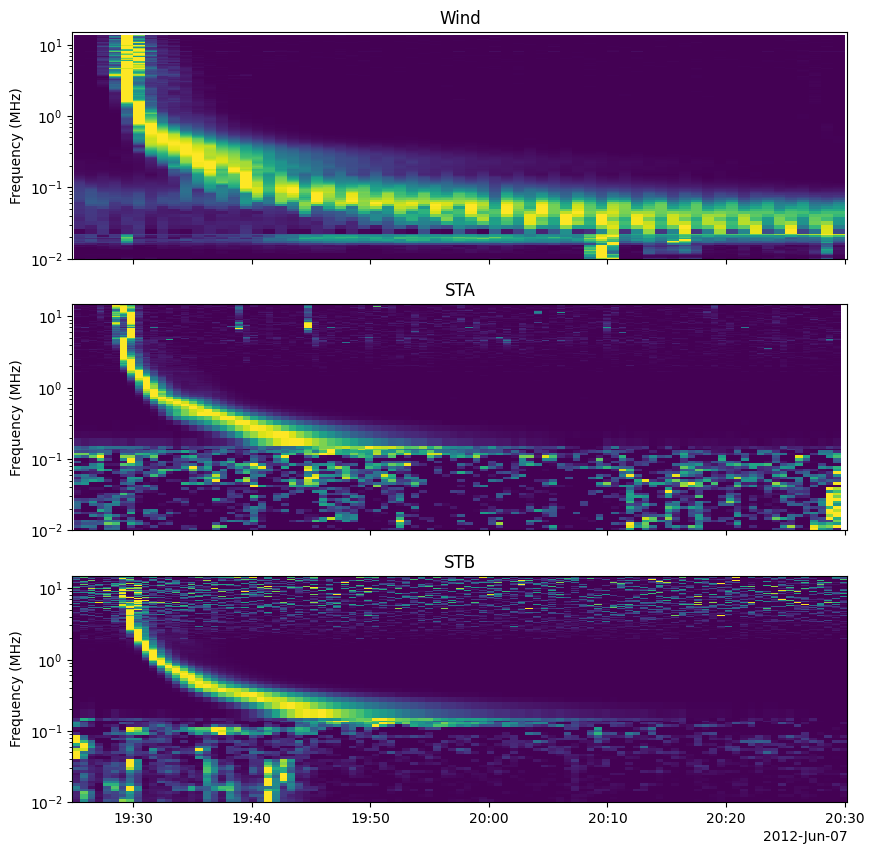

In [8]:
def plot_spectrograms(specs,figsize=(10,10),fmin=1e-2,fmax=15) :
    fig,axes=plt.subplots(figsize=figsize,nrows=3,sharex=True,sharey=True)
    for ax,(name,spec_dict) in zip(axes,specs.items()) :
        psdarray = spec_dict["psdarr"]
        ax.pcolormesh(spec_dict["dt"],
                      spec_dict["freqs"].to("MHz").value,
                      (psdarray/np.nanmax(psdarray,axis=0)).T,
                      vmin=0, vmax=1
                      )
        ax.set_title(name)
        ax.set_ylabel("Frequency (MHz)")
        ax.set_yscale("log")
        ax.set_ylim(fmin,fmax)
    return fig,axes
fig,axes=plot_spectrograms(specs)

### Step 2 : Get Spacecraft Position Vectors

In [9]:
# Create spacecraft Coordinates
sta_inertial = astrospice.generate_coords('STEREO AHEAD',[dt_burst_start])
stb_inertial = astrospice.generate_coords('STEREO BEHIND',[dt_burst_start])
earth_inertial = astrospice.generate_coords('Earth',[dt_burst_start])

## Modify the radial distance of earth to make an L1 position 
# e.g. https://www.mat.univie.ac.at/~westra/lagrangepoints.pdf region 3
earth_inertial.representation_type="spherical"
L1_modifier = 1.0- ((const.M_earth.value/
                    (const.M_earth.value+const.M_sun.value))
                    /3)**(1/3)
r_L1 = earth_inertial.distance * L1_modifier
L1_inertial = coordinates.SkyCoord(
    distance = r_L1, 
    ra = earth_inertial.ra,
    dec = earth_inertial.dec,
    frame="icrs"
)
L1_inertial.representation_type="cartesian"

In [10]:
## Rotate into ecliptic plane 
frame = coordinates.HeliocentricMeanEcliptic
sta_eclip = sta_inertial.transform_to(frame)
stb_eclip = stb_inertial.transform_to(frame)
L1_eclip = L1_inertial.transform_to(frame)
for sc in [sta_eclip,stb_eclip,L1_eclip] : sc.representation_type = "cartesian"
    
## Package into Dictionary :
sc_pos_dict = {
    "STA":sta_eclip,
    "STB":stb_eclip,
    "Wind":L1_eclip,
}

Text(0, 0.5, 'Y-heliocentricmeanecliptic (R_sun)')

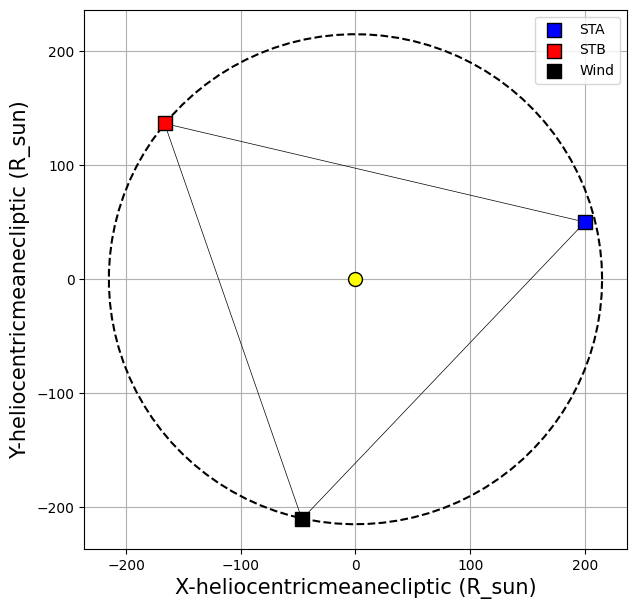

In [11]:
fig,ax=plt.subplots(figsize=(7,7))

units="R_sun"

ax.scatter(0,0,s=100,color="yellow",edgecolor="black",zorder=100)

ax.plot(
    (np.cos(np.linspace(0,2*np.pi,100))*1*u.au).to(units),
    (np.sin(np.linspace(0,2*np.pi,100))*1*u.au).to(units),
    linestyle="--",color="black",
)

for (name,sc),color in zip(sc_pos_dict.items(),["blue","red","black"]): 
    ax.scatter(sc.x.to(units),sc.y.to(units),
               marker='s',s=100,edgecolor="black",
               zorder=100,label=name,color=color
              )
ax.plot([sc.x.to(units) for sc in sc_pos_dict.values()]
        +[list(sc_pos_dict.values())[0].x.to(units)],
        [sc.y.to(units) for sc in sc_pos_dict.values()]
        +[list(sc_pos_dict.values())[0].y.to(units)],
        color="black",linewidth=0.5
       )
    
ax.legend()
ax.grid()
ax.set_xlabel(f"X-{frame.name} ({units})",fontsize=15)
ax.set_ylabel(f"Y-{frame.name} ({units})",fontsize=15)


### Step 3a - Extract Features from Spectrograms

We iterate over each frequency channel in the input spectrograms and extract from the timeseries three features which we call "rise", "peak" and "fall" which respectively are: the first timestamp where the flux rises above half the peak in the channel, the timestamp when the flux is equal to the peak value, and the the last timestamp before the flux falls below half the peak value.

In [12]:
feature_dict = {}
for name,spec_dict in specs.items() :
    feature_times = []
    for timeseries in spec_dict['psdarr'].T :
        thresh_inds = np.where(timeseries >= np.nanmax(timeseries)/2)[0]
        # Datetimes
        rise = spec_dict['dt'][thresh_inds[0]]
        peak = spec_dict['dt'][np.argmax(timeseries)]
        fall = spec_dict['dt'][thresh_inds[-1]]
        # Unix Timestamps
        rise_ts = spec_dict['ts'][thresh_inds[0]]
        peak_ts = spec_dict['ts'][np.argmax(timeseries)]
        fall_ts = spec_dict['ts'][thresh_inds[-1]]
        feature_times.append([rise,peak,fall,rise_ts,peak_ts,fall_ts])
    feature_dict[name] = np.vstack([spec_dict['freqs'].to("MHz").value,
                                    *np.array(feature_times).T
                                   ])        

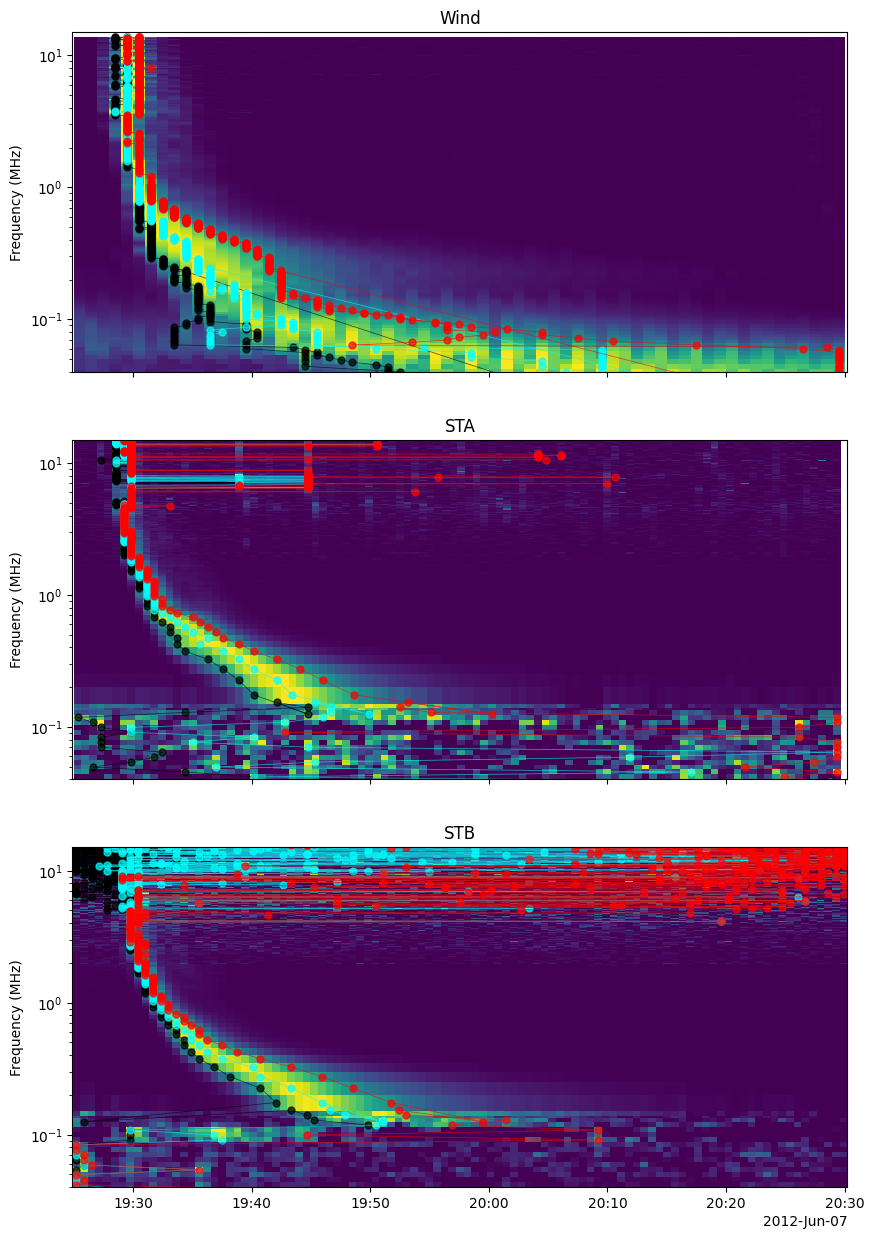

In [13]:
### Plot up the feature extractions on top of the original spectrogtrams
fig,axes = plot_spectrograms(specs,figsize=(10,15),fmin=4e-2)
ms=5;lw=0.5;alpha=0.7
for ax,sc_features in zip(axes,feature_dict.values()) :
    ax.plot(sc_features[1,:],sc_features[0,:],"o",color="black",
            linestyle="-",lw=lw,ms=ms,alpha=alpha)
    ax.plot(sc_features[2,:],sc_features[0,:],"o",color="cyan",
            linestyle="-",lw=lw,ms=ms,alpha=alpha)
    ax.plot(sc_features[3,:],sc_features[0,:],"o",color="red",
            linestyle="-",lw=lw,ms=ms,alpha=alpha)

### Step 3b - Fit smooth curve through extracted features

Following Badman+[2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...938...95B/abstract), we fit the datapoints (1/f,t) with a smooth curve. The burst shape here is is noticeably different in character to the one studied in that work however, and is better approximated by a curve $t=Ax^4 + B x^3 + C x^2 + D x + E$, where $x=\log_10(1/f)$ (as opposed to a quadratic in $(1/f)$).

In [14]:
def fit_func(x,A,B,C,D,E) : return A*x**4 + B*x**3 + C*x**2 + D*x + E

numin = 0.3
numax=7
fit_dict = {}
for name,sc_features in feature_dict.items() : 
    nu = 1/sc_features[0,:]
    x = np.log10(nu[(nu > numin) & (nu<numax)].astype(float))
    y = sc_features[4,(nu > numin) & (nu<numax)]#-1.3391e9
    y = y[np.argsort(x)]
    x = x[np.argsort(x)]
    xrefl = 2*x[0]-x
    yrefl = y
    x_all = np.concatenate([xrefl,x])
    y_all = np.concatenate([yrefl,y])
    fit = curve_fit(fit_func,x_all,y_all)
    fit_dict[name] = (fit,numin,numax)

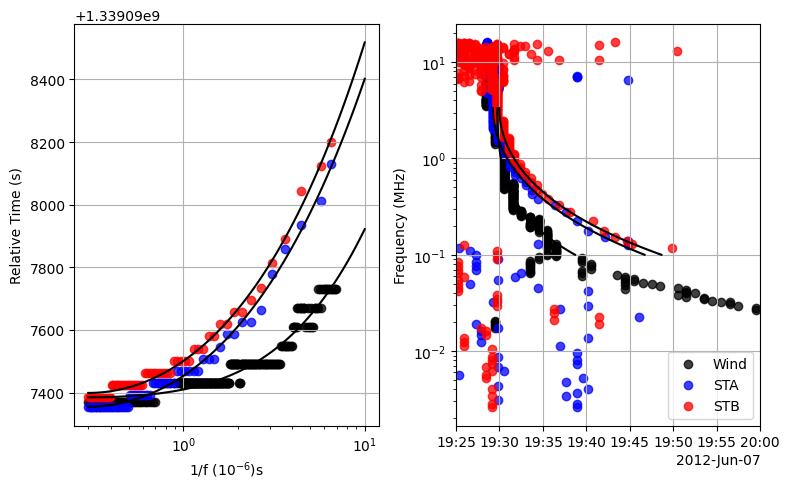

In [15]:
nu_arr =np.logspace(np.log10(numin),1,100)
fig,axes = plt.subplots(figsize=(8,5),ncols=2)
for name,fit,sc_features,color in zip(fit_dict.keys(),
                                       fit_dict.values(),
                                       feature_dict.values(),
                                       ["black","blue","red"]
                                      ) :
    nu = 1/sc_features[0,:]
    x = np.log10(nu[(nu > numin) & (nu<numax)].astype(float))
    y = sc_features[4,(nu > numin) & (nu<numax)]#-1.3391e9
    y = y[np.argsort(x)]
    x = x[np.argsort(x)]
    
    axes[0].scatter(10**x,y,alpha=0.75,color=color)
    axes[0].plot(nu_arr,
            fit_func(np.log10(nu_arr), *fit[0][0]),zorder=100,color="black",linewidth=1.5
           )
    
    axes[1].scatter(sc_features[1,:],
                    sc_features[0,:],alpha=0.75,
                    label=name,color=color
                   )
    axes[1].plot([datetime.utcfromtimestamp(t) for t in fit_func(np.log10(nu_arr), *fit[0][0])],
                 1/nu_arr*u.MHz,zorder=100,color="black",linewidth=1.5
                )
    
axes[0].set_ylabel("Relative Time (s)")
axes[0].set_xlabel("1/f (10$^{-6}$)s")
axes[0].grid()

axes[1].set_ylabel("Frequency (MHz)")
axes[1].set_yscale("log")
axes[1].grid()

axes[1].legend()

axes[1].set_xlim([datetime(2012,6,7,19,25),
                  datetime(2012,6,7,20)]
                  )

axes[0].set_xscale("log")
plt.tight_layout()

### Step 4 : Perform TDOA Triangulation of Burst Trajectory

Finally, we have extracted our feature from the different spacecraft and through fitting have reduced noise, smoothed and aligned the different measurements to the same array of frequencies. We now ready to combine the spacecraft position data and the delay of arrival of the burst between pairs of spacecraft into source locations.

In [16]:
def rot_2D(angle_in_radians) :
    return np.array([[np.cos(angle_in_radians), -np.sin(angle_in_radians)],
                     [np.sin(angle_in_radians),  np.cos(angle_in_radians)]
                    ])

In [17]:
sc_pos = list(sc_pos_dict.values())

# Get relative position vectors
r01 = (np.array([sc_pos_dict["STA"].x-sc_pos_dict["Wind"].x,
                sc_pos_dict["STA"].y-sc_pos_dict["Wind"].y]
                )*sc_pos[0].x.unit).to(units).flatten()
r02 = (np.array([sc_pos_dict["STB"].x-sc_pos_dict["Wind"].x,
                sc_pos_dict["STB"].y-sc_pos_dict["Wind"].y]
               )*sc_pos[0].x.unit).to(units).flatten()
r12 = (np.array([sc_pos_dict["STB"].x-sc_pos_dict["STA"].x,
                sc_pos_dict["STB"].y-sc_pos_dict["STA"].y]
              )*sc_pos[0].x.unit).to(units).flatten()

# Properties of baseline vectors in input frame.
rmag01,rmag02,rmag12=np.linalg.norm(r01),np.linalg.norm(r02),np.linalg.norm(r12)
rhat01,rhat02,rhat12 = r01/rmag01,r02/rmag02,r12/rmag12
theta102 = np.arccos(np.dot(rhat01,rhat02))
theta102 *= np.sign(rhat01[0]*rhat02[1] - rhat01[1]*rhat02[0])

## Nu == Wavenumber == reciprocal of frequency in units of 1/MHz <- improve with astropy units...
nu_min = list(fit_dict.values())[0][1] ## Assumes same frequency range for all fits
nu_max = list(fit_dict.values())[0][2]
nu_arr = np.logspace(np.log10(nu_min),
                     np.log10(nu_max),
                     100)
freq_arr = 1/nu_arr*u.MHz

# Reconstruct time of arrivals from fits
toa0 = fit_func(np.log10(nu_arr),*(fit_dict["Wind"][0][0]))*u.s
toa1 = fit_func(np.log10(nu_arr),*(fit_dict["STA"][0][0]))*u.s
toa2 = fit_func(np.log10(nu_arr),*(fit_dict["STB"][0][0]))*u.s

# Convert time delays to path length difference (assuming lightspeed propagation)
ct01 = ((toa1-toa0)*const.c).to(units)
ct02 = ((toa2-toa0)*const.c).to(units)
ct12 = ((toa2-toa1)*const.c).to(units)

 # If measured delay of arrival larger than time to prop between sc return nan
ct01[ct01/np.linalg.norm(r01) > 1] = np.nan
ct02[ct02/np.linalg.norm(r02) > 1] = np.nan
ct12[ct12/np.linalg.norm(r12) > 1] = np.nan

# Hyperbola parameterization values
a_x = rmag01/2.*(1.-(ct01/rmag01).value**2)
b_x = (ct01/rmag01).value
a_y = (rmag02/2.*(1.-(ct02/rmag02).value**2)-a_x*np.cos(theta102))/np.sin(theta102)
b_y = ((ct02/rmag02).value-b_x*np.cos(theta102))/np.sin(theta102)

# Linear Parameterization of Source 
r_WS1 = 1./2./(b_x**2+b_y**2-1)*(-2*(a_x*b_x+a_y*b_y) + (4.*(a_x*b_x+a_y*b_y
        )**2 - 4.*(b_x**2+b_y**2-1)*(a_x**2+a_y**2))**0.5)
r_WS2 = 1./2./(b_x**2+b_y**2-1)*(-2*(a_x*b_x+a_y*b_y) - (4.*(a_x*b_x+a_y*b_y
        )**2 - 4.*(b_x**2+b_y**2-1)*(a_x**2+a_y**2))**0.5)  
x1 = a_x + b_x*r_WS1
y1 = a_y + b_y*r_WS1
x2 = a_x + b_x*r_WS2
y2 = a_y + b_y*r_WS2

rshift = np.array([sc_pos_dict["Wind"].x.to(units),sc_pos_dict["Wind"].y.to(units)])

# Rotate Solution to Inout Frame
rot2input = rot_2D(np.arctan2(rhat01[1],rhat01[0]))

[x1,y1] = np.dot(rot2input,[x1,y1])
x1 += rshift[0]
y1 += rshift[1]
source_pos = [x1,y1]

[x2,y2] = np.dot(rot2input,[x2,y2])
x2 += rshift[0]
y2 += rshift[1]
alias_pos = [x2,y2]

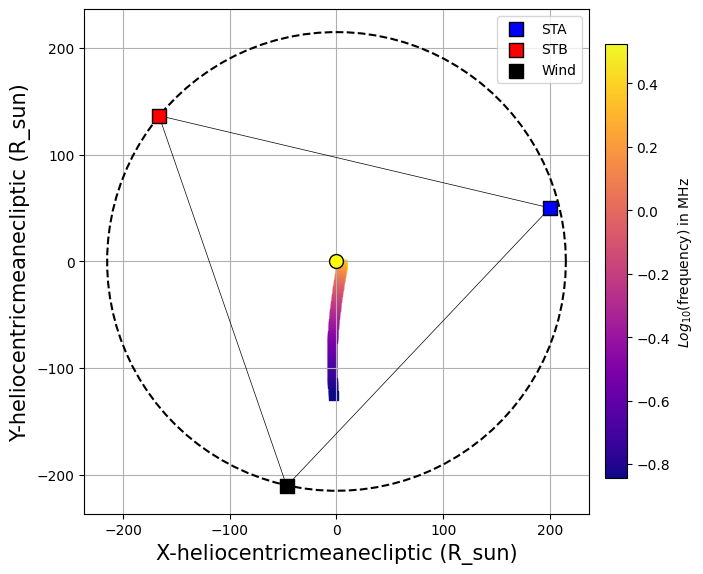

In [52]:
fig, ax = plt.subplots(figsize=(7,7))

units = 'R_sun'

ax.scatter(0, 0, s=100, color="yellow", edgecolor="black", zorder=100)

ax.plot(
    (np.cos(np.linspace(0,2*np.pi,100))*1*u.au).to(units),
    (np.sin(np.linspace(0,2*np.pi,100))*1*u.au).to(units),
    linestyle="--", color="black")

cmap = plt.cm.plasma
im = ax.scatter(source_pos[0], source_pos[1], marker='s',
                cmap=plt.cm.get_cmap(cmap), c=np.log10(freq_arr.value),
                norm=plt.Normalize(np.nanmin(np.log10(freq_arr.value)),
                                   np.nanmax(np.log10(freq_arr.value))
                                  )
                    )

for (name,sc),color in zip(sc_pos_dict.items(),["blue","red","black"]): 
    ax.scatter(sc.x.to(units),sc.y.to(units),
               marker='s',s=100,edgecolor="black",
               zorder=100,label=name,color=color
              )
ax.plot([sc.x.to(units) for sc in sc_pos_dict.values()]
        +[list(sc_pos_dict.values())[0].x.to(units)],
        [sc.y.to(units) for sc in sc_pos_dict.values()]
        +[list(sc_pos_dict.values())[0].y.to(units)],
        color="black",linewidth=0.5
       )
    
ax.legend()
ax.grid()
plt.colorbar(im, ax=ax, fraction=0.04, pad=0.03, label=r'$Log_{10}$(frequency) in MHz')
ax.set_xlabel(f"X-{frame.name} ({units})", fontsize=15)
ax.set_ylabel(f"Y-{frame.name} ({units})", fontsize=15)
ax.set_aspect('equal', 'box')
plt.show()